In [9]:
import sys, re, math, time
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import collections
from collections import OrderedDict
from matplotlib.pyplot import cm
%load_ext autoreload
%autoreload 2
from run_experiments import *
from datahelper import *
import keras.metrics
keras.metrics.cindex_score = cindex_score
from sklearn.metrics import mean_squared_error, f1_score

from keras.models import load_model 
fpath = '../data/davis/'
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ligands = json.load(open(fpath+"ligands_can.txt"), object_pairs_hook=OrderedDict)
proteins = json.load(open(fpath+"proteins.txt"), object_pairs_hook=OrderedDict)

Y = pickle.load(open(fpath + "Y","rb"), encoding='latin1') ### TODO: read from raw

In [3]:
perfmeasure = get_cindex
runmethod = build_combined_categorical
FLAGS = argparser()
FLAGS.log_dir = FLAGS.log_dir + str(time.time()) + "/"
FLAGS.num_windows = 32
FLAGS.seq_window_lengths = [4]
FLAGS.smi_window_lengths = [4]
FLAGS.batch_size = 256
FLAGS.num_epoch = 1000
FLAGS.max_seq_len = 1000
FLAGS.max_smi_len = 95
FLAGS.dataset_path= '../data/davis/'
FLAGS.problem_type = 1
FLAGS.log_dir = '../logs'


In [4]:
dataset = DataSet( fpath = FLAGS.dataset_path, ### BUNU ARGS DA GUNCELLE
                      setting_no = FLAGS.problem_type, ##BUNU ARGS A EKLE
                      seqlen = FLAGS.max_seq_len,
                      smilen = FLAGS.max_smi_len,
                      need_shuffle = False )
# set character set size
FLAGS.charseqset_size = dataset.charseqset_size 
FLAGS.charsmiset_size = dataset.charsmiset_size 

XD, XT, Y = dataset.parse_data(fpath = FLAGS.dataset_path)

XD = np.asarray(XD)
XT = np.asarray(XT)
Y = np.asarray(Y)

drugcount = XD.shape[0]
print(drugcount)
targetcount = XT.shape[0]
print(targetcount)

FLAGS.drug_count = drugcount
FLAGS.target_count = targetcount

label_row_inds, label_col_inds = np.where(np.isnan(Y)==False)  #basically finds the point address of affinity [x,y]

if not os.path.exists(figdir):
    os.makedirs(figdir)

Y = np.mat(np.copy(Y))

train_drugs, train_prots,  train_Y = prepare_interaction_pairs(XD, XT, Y, label_row_inds, label_col_inds)

Reading ../data/davis/ start
Read ../data/davis/ start
68
442


In [5]:

data_path='../../data/'
XD_dtc, XT_dtc, Y_dtc = get_DTC_train(data_path+'dtc_for_deepDTA.csv', FLAGS.max_smi_len, FLAGS.max_seq_len)


In [6]:
from sklearn.model_selection import PredefinedSplit, KFold, ParameterGrid
def get_n_fold_by_drugs(all_drugs, n_splits=5):
    unique_drugs = np.unique(all_drugs, axis=0)
    test_folds = np.ones(all_drugs.shape[0])
    kf = KFold(n_splits, random_state=15)
    
    j = 0
    for _, validation_drugs in kf.split(np.arange(unique_drugs.shape[0])):
        val_inds = []

        for drug_ind in validation_drugs:
            willbe_added =  list(np.where((~(all_drugs==unique_drugs[drug_ind, :])).sum(axis=1) == 0)[0])
            val_inds +=   willbe_added
        test_folds[val_inds] = j
        j += 1
    
    return PredefinedSplit(test_folds)

In [7]:
from sklearn.model_selection import train_test_split
all_train_drugs = np.concatenate((np.asarray(train_drugs), np.asarray(XD_dtc)), axis=0)
all_train_prots = np.concatenate((np.asarray(train_prots), np.asarray(XT_dtc)), axis=0)
all_train_Y = np.concatenate((np.asarray(train_Y), np.asarray(Y_dtc)), axis=0)
all_train_Y = -np.log10(1e-8+all_train_Y/1e9)

val_inds = get_n_fold_by_drugs(all_train_drugs, n_splits=5)


In [8]:
from os import path
class CustomStopper(keras.callbacks.EarlyStopping):
    def __init__(self, monitor='val_loss',
             min_delta=0, patience=0, verbose=0, mode='auto', start_epoch = 100): # add argument for starting epoch
        super(CustomStopper, self).__init__()
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

param_grid = ParameterGrid([
    {
        'num_filters': [24, 32, 48],
        'filter_length': [4, 8],
        'dropout': [0.1, 0.2, 0.3],
        'apply_bn': [True, False]
    }
])

results = []
with tf.device("/device:GPU:0"):
    for ind in range(len(param_grid)):
        params = param_grid[ind]
        if params['apply_bn']!=False:
            continue

        print(params)
        param_name = 'dropout'+str(params['dropout'])+'-filter_length'+str(params['filter_length'])+'-num_filters'+\
                    str(params['num_filters']) + '-apply_bn'+str(params['apply_bn'])

        early_stopping_callback = CustomStopper(monitor='val_loss', patience=20, start_epoch=50)
        fold_id = 0
        for tr_fold, val_fold in val_inds.split():

            model_name='checkpoints/davis_dtc_dta_'+param_name+'fold'+str(fold_id)
            if path.exists(model_name+'.h5'):
                continue
            
            checkpoint_callback = ModelCheckpoint(model_name+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

            if fold_id >= 3:
                break
            XD_train, XT_train, Y_train = all_train_drugs[tr_fold], all_train_prots[tr_fold], all_train_Y[tr_fold]
            XD_val, XT_val, Y_val = all_train_drugs[val_fold], all_train_prots[val_fold], all_train_Y[val_fold]

            gridmodel = build_combined_categorical(FLAGS, params['num_filters'], params['filter_length'], 
                                           params['filter_length'], params['dropout'], apply_bn=params['apply_bn'])

            gridres = gridmodel.fit(([XD_train, XT_train ]), Y_train, batch_size=FLAGS.batch_size, epochs=100, 
                    validation_data=( ([np.array(XD_val), np.array(XT_val) ]), np.array(Y_val))
                       ,callbacks=[early_stopping_callback, checkpoint_callback], verbose=2)
            
            predicted_labels = gridmodel.predict([np.array(XD_val), np.array(XT_val)])[:, 0]
            loss, rperf2 = gridmodel.evaluate(([np.array(XD_val),np.array(XT_val) ]), np.array(Y_val), verbose=0)
            results.append({**params, 'filename': model_name, 'fold_id': ind, 'loss': loss, 'cindex': rperf2,
                           'rmse':  np.sqrt(mean_squared_error(Y_val, predicted_labels)),
                           'f1': f1_score(Y_val>7, predicted_labels>7)})
            fold_id += 1

{'apply_bn': False, 'filter_length': 4, 'num_filters': 24, 'dropout': 0.1}
{'apply_bn': False, 'filter_length': 4, 'num_filters': 32, 'dropout': 0.1}
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 37669 samples, validate on 10798 samples
Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[256,128,1,1000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/conv1d_4/convolution/Conv2D_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1d_4/convolution/ExpandDims, PermConstNHWCToNCHW-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/mul/_193}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1674_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
from sklearn.metrics import mean_squared_error, f1_score

predicted_labels = gridmodel.predict([np.array(XD_val), np.array(XT_val) ])

print('cindex:', get_cindex(Y_val, predicted_labels))
print('rmse:', np.sqrt(mean_squared_error(Y_val, predicted_labels)))
#print('pearsonr:', pearsonr(Y_val, predicted_labels[:, 0]))
#print('spearmanr:', np.sqrt(spearmanr(val_Y, predicted_labels[:, 0])))
print('f1:', np.sqrt(f1_score(Y_val>7, predicted_labels>7)))

#v0.1
#cindex: [0.81675458]
#rmse: 0.8683109279804
#f1: 0.6599120175960898
#checkpoint
#cindex: [0.79595819]
#rmse: 0.7753355061972348
#f1: 0.6260990336999411

#v0.2
#cindex: [0.80586742]
#rmse: 0.8517248117216893
#f1: 0.618852747755276
#checkpoint
#cindex: [0.82653753]
#rmse: 0.7971002447060451
#f1: 0.6114717550558165

In [11]:
gridmodel = load_model('checkpoints/davis_dtc_dta_b1c21098f5adaae3006535fec0f014bfold0.h5')
XD_test, XT_test = get_DTC_train('../data/dtc_test_for_deepDTA.csv', FLAGS.max_smi_len, FLAGS.max_seq_len, with_label=False)
XD_test, XT_test = np.asarray(XD_test), np.asarray(XT_test)
predicted_labels = gridmodel.predict([np.array(XD_test), np.array(XT_test) ])


(array([106., 108.,  75.,  53.,  27.,  20.,  24.,  10.,   2.,   5.]),
 array([4.77294  , 5.172059 , 5.571178 , 5.970297 , 6.3694158, 6.7685347,
        7.167654 , 7.566773 , 7.965892 , 8.36501  , 8.76413  ],
       dtype=float32),
 <a list of 10 Patch objects>)

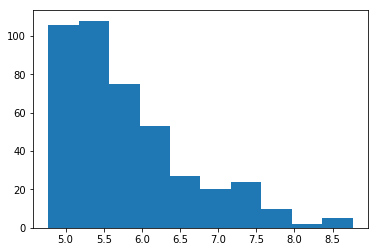

In [16]:
plt.hist(predicted_labels)

In [17]:
submission_data = pd.read_csv(data_path+'round_1_template.csv')
submission_data.loc[:, 'pKd_[M]_pred'] = predicted_labels
submission_data.to_csv(data_path+'submission_file1.csv', index=None)